## Load Dataset and Import Libraries

In [1]:
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import mido
from mido import MidiFile, bpm2tempo, tick2second
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import numpy as np
import pygame
import time

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Directory where the raw data will be extracted
raw_data_extracted = 'raw_data_unzipped'

#### Clean Data

In [3]:
# Function to delete a directory and its contents
def delete_dir(dir_to_delete):
    try:
        file_count = sum([len(files) for r, d, files in os.walk(dir_to_delete)])
        shutil.rmtree(dir_to_delete)
        print(f"Directory {dir_to_delete} and all its contents ({file_count} files) have been successfully deleted.")
    except Exception as e:
        print(f"An error occurred while trying to delete the directory: {e}")

# This is in case of testing and if the initial raw files need to be deleted. 
delete_dir(raw_data_extracted)

An error occurred while trying to delete the directory: [WinError 3] The system cannot find the path specified: 'raw_data_unzipped'


In [4]:
# Function to unzip a file
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

raw_data_zip = 'raw_data/midi_classic_music_data.zip'
raw_data_extracted = unzip_file(raw_data_zip, raw_data_extracted)

display(f"Extracted to: {raw_data_extracted}")

'Extracted to: raw_data_unzipped'

In [5]:
# Function to move contents of a directory up one level
def move_contents_up_one_dir(path):
    path = os.path.abspath(path)
    parent_dir = os.path.dirname(path)
    if path == parent_dir or not os.path.exists(path):
        print("Operation not allowed or path does not exist.")
        return
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), os.path.join(parent_dir, item))
    os.rmdir(path)
    print(f"All contents moved from {path} to {parent_dir} and directory removed.")

move_contents_up_one_dir(os.path.join(raw_data_extracted, 'midiclassics'))

All contents moved from c:\Users\eterp\OneDrive\Documents\USD\Neural Networks and Deep Learning (AAI-511-04)\Final Project\AAI-511-Final-Project\raw_data_unzipped\midiclassics to c:\Users\eterp\OneDrive\Documents\USD\Neural Networks and Deep Learning (AAI-511-04)\Final Project\AAI-511-Final-Project\raw_data_unzipped and directory removed.


In [6]:
# Function to rename .MID files to .mid
def rename_mid_files(directory):
    rename_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.MID'):
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, file[:-4] + '.mid')
                os.rename(old_file_path, new_file_path)
                rename_count += 1
                # print(f'Renamed: {old_file_path} to {new_file_path}')
    return rename_count

# Function to delete .zip files
def delete_zip_files(directory):
    delete_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                delete_count += 1
                # print(f'Deleted: {file_path}')
    return delete_count

# Rename .MID files to .mid
renamed_files_count = rename_mid_files(raw_data_extracted)
print(f'Total .MID files renamed: {renamed_files_count}')

# Delete .zip files
deleted_files_count = delete_zip_files(raw_data_extracted) 
print(f'Total .zip files deleted: {deleted_files_count}')

Total .MID files renamed: 732
Total .zip files deleted: 31


## Data Pre-Processing

In [7]:
# Function to Categorize Files by Directory
def categorize_files_by_dir(path):
    files_and_dirs = os.listdir(path)
    directories = {name for name in files_and_dirs if os.path.isdir(os.path.join(path, name))}
    file_dict = {}
    unassigned_files = {}

    for file_name in files_and_dirs:
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.mid'):
            first_word = file_name.split()[0]
            if first_word in directories:
                if first_word not in file_dict:
                    file_dict[first_word] = []
                file_dict[first_word].append(file_name)
            else:
                if first_word not in unassigned_files:
                    unassigned_files[first_word] = []
                unassigned_files[first_word].append(file_name)

    return file_dict, unassigned_files, sorted(directories)

# Function to Display Information about Categorized and Unassigned Files
def display_info(categorized_files, unassigned_files):
    print("Categorized Files Summary:")
    for key, files in categorized_files.items():
        print(f"Artist '{key}': {len(files)} files")
    
    print("\nUnassigned Files Summary:")
    if unassigned_files:
        for key, files in unassigned_files.items():
            print(f"Artist '{key}': {len(files)} files")
    else:
        print("No unassigned files found.")

# Categorize files
categorized_files, unassigned_files, all_artists = categorize_files_by_dir(raw_data_extracted)

print("Categorized Files Summary:")
for key, files in categorized_files.items():
    print(f"Artist {key}: {len(files)} files")

print("\nUnassigned Files Summary:")
for key, files in unassigned_files.items():
    print(f"Artist {key}: {len(files)} files")

Categorized Files Summary:
Artist Bartok: 2 files
Artist Debussy: 4 files
Artist Dvorak: 6 files
Artist Ginastera: 1 files
Artist Grieg: 2 files
Artist Kuhlau: 5 files
Artist Liszt: 7 files
Artist Sibelius: 1 files
Artist Tchaikovsky: 13 files
Artist Wagner: 1 files

Unassigned Files Summary:
Artist Bizet: 5 files
Artist Buxethude: 13 files
Artist C.P.E.Bach: 1 files
Artist Diabelli: 11 files
Artist Gershuin: 1 files
Artist Lizt: 1 files
Artist meditation: 1 files
Artist Nicolai: 1 files
Artist Pachebel: 5 files
Artist Pollen: 1 files
Artist Reger: 3 files
Artist Reinecke: 3 files
Artist Rimsky: 1 files
Artist Rothchild: 11 files
Artist Rothchlid: 1 files
Artist Tchaicovsky: 1 files


#### Correct File Placement

In [8]:
# Correct File Placement
corrections_to_file_placement = {
    'Pachebel': 'Pachelbel',
    'Lizt': 'Liszt'
}

for old_key, new_key in corrections_to_file_placement.items():
    if old_key in unassigned_files:
        unassigned_files[new_key] = unassigned_files.pop(old_key)

In [9]:
# Function to Move Folder Contents
def move_folder_contents(src_folder, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    for item in os.listdir(src_folder):
        src_item = os.path.join(src_folder, item)
        dest_item = os.path.join(dest_folder, item)
        
        if os.path.isdir(src_item):
            shutil.move(src_item, dest_folder)
        else:
            shutil.move(src_item, dest_item)
    
    # Delete the source folder regardless of its contents
    delete_dir(src_folder)

# Correct misnamed folders and move contents accordingly
name_corrections_folder = {
    "Albe'niz": "Albeniz",
    "Albe╠üniz": "Albeniz",
    "Mendelsonn": "Mendelssohn",
    "Tchakoff": "Tchaikovsky",
    "Handel": "Handel",
    "Haendel": "Handel",
    "Straus": "Strauss",
    "Strauss, J": "Strauss"
}

In [10]:
for src_folder, dest_folder in name_corrections_folder.items():
    src_path = os.path.join(raw_data_extracted, src_folder)
    dest_path = os.path.join(raw_data_extracted, dest_folder)
    print(f"Moving contents from {src_path} to {dest_path}...")
    move_folder_contents(src_path, dest_path)

print("Folder contents moved and directories deleted successfully.")

Moving contents from raw_data_unzipped\Albe'niz to raw_data_unzipped\Albeniz...
Directory raw_data_unzipped\Albe'niz and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped\Albe╠üniz to raw_data_unzipped\Albeniz...
Directory raw_data_unzipped\Albe╠üniz and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped\Mendelsonn to raw_data_unzipped\Mendelssohn...
Directory raw_data_unzipped\Mendelsonn and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped\Tchakoff to raw_data_unzipped\Tchaikovsky...
Directory raw_data_unzipped\Tchakoff and all its contents (0 files) have been successfully deleted.
Moving contents from raw_data_unzipped\Handel to raw_data_unzipped\Handel...
Directory raw_data_unzipped\Handel and all its contents (1 files) have been successfully deleted.
Moving contents from raw_data_unzipped\Haendel to raw_data_unzipped\Handel...
Directory raw

#### Move Files to Directories

In [11]:
# Function to move files to their respective directories
def move_files_to_directories(base_path, files_to_move):
    for directory, files in files_to_move.items():
        dir_path = os.path.join(base_path, directory)
        # Create directory if it doesn't exist
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        # Move each file to the new directory
        for file_name in files:
            shutil.move(os.path.join(base_path, file_name), os.path.join(dir_path, file_name))

# Move categorized and unassigned files to their respective directories
move_files_to_directories(raw_data_extracted,categorized_files)
move_files_to_directories(raw_data_extracted,unassigned_files)

# Print the final structure of directories
print({name for name in os.listdir(raw_data_extracted) if os.path.isdir(os.path.join(raw_data_extracted, name))})

{'Botsford', 'Reinecke', 'Holst', 'Shostakovich', 'Durand, MA', 'Mussorgski', 'Burgmuller', 'Saint-Saens', 'Tchaicovsky', 'Haydn', 'Swinstead', 'Durand, E', 'MacCunn', 'Scarlatti', 'Ravel', 'Meyerbeer', 'Rimsky-Korsakov', 'Gershwin', 'Poulenc', 'Czerny', 'Skriabin', 'Jensen', 'Bartelet', 'Clementi', 'Prokofiev', 'Rothchild', 'Chopin', 'Ambroise', 'Alkan', 'Frescobaldi', 'Satie', 'C.P.E.Bach', 'Czibulka', 'Bizet', 'Moszkowski', 'Bartok', 'Faure', 'Albeniz', 'Flotow', 'Bernstein', 'Field', 'Pollen', 'Dvorak', 'Wolf', 'Raff', 'Hummel', 'Wagner', 'Suppe', 'Hemery', 'Schoenberg', 'Herold', 'Verdi', 'Jakobowski', 'Pachelbel', 'Tarrega', 'Couperin', 'Borodin', 'German', 'Ganne', 'Sinding', 'Pridhan', 'Lange', 'Taube', 'Paderewski', 'Arndt', 'Lecuona', 'Paganini', 'Handel', 'Holst, M', "Varios - Ti'tulo desconocido", 'Buxehude', 'Schumann', 'Sullivan', 'Thomas', 'Stravinski', 'Grieg', 'Sibelius', 'Lavallee', 'Lemire', 'Arensky', 'Rimsky', 'Heidrich', 'Dussek', 'Peterson-Berger', 'Debussy', 'Be

Error processing raw_data_unzipped\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


<Figure size 1000x600 with 0 Axes>

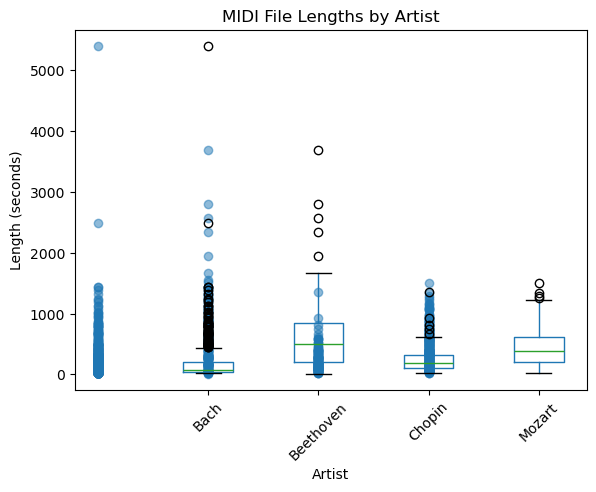

In [12]:
# Function to calculate the length of a MIDI file
def calculate_midi_length(file_path):
    try:
        midi_file = MidiFile(file_path)
        total_time = 0.0

        for track in midi_file.tracks:
            current_time = 0.0
            tempo = bpm2tempo(120)  # Default tempo is 120 BPM
            for msg in track:
                if msg.is_meta and msg.type == 'set_tempo':
                    tempo = msg.tempo
                current_time += tick2second(msg.time, midi_file.ticks_per_beat, tempo)
            if current_time > total_time:
                total_time = current_time

        return total_time
    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Define the base directory and artists
base_directory = raw_data_extracted

# Required Composers
specific_artists = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
midi_lengths = {}

# Recursively walk through the directories and calculate lengths
for root, dirs, files in os.walk(base_directory):
    for file in files:
        if file.endswith('.mid'):
            file_path = os.path.join(root, file)
            relative_path = os.path.relpath(file_path, base_directory)
            for artist in specific_artists:
                if artist in relative_path:
                    midi_length = calculate_midi_length(file_path)
                    if midi_length is not None:
                        midi_lengths[relative_path] = midi_length
                    break

# Create a DataFrame for plotting
data = {'Artist': [], 'Length': []}
for path, length in midi_lengths.items():
    for artist in specific_artists:
        if artist in path:
            data['Artist'].append(artist)
            data['Length'].append(length)
            break

df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(10, 6))
df.boxplot(by='Artist', column=['Length'], grid=False)
plt.scatter(df['Artist'], df['Length'], alpha=0.5)
plt.title('MIDI File Lengths by Artist')
plt.suptitle('')
plt.xlabel('Artist')
plt.ylabel('Length (seconds)')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Function to walk through directories and calculate MIDI lengths for a specific artist
def get_midi_lengths_for_artist(artist_directory):
    midi_lengths = {}
    file_count = 0
    
    for root, dirs, files in os.walk(artist_directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_directory)
                midi_length = calculate_midi_length(file_path)
                if midi_length is not None:
                    midi_lengths[relative_path] = midi_length
                    file_count += 1
    
    return midi_lengths, file_count

base_directory = raw_data_extracted
specific_artists = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold all results
all_midi_lengths = {}
artist_file_counts = {}

# Get the MIDI lengths and file counts for each artist
for artist in specific_artists:
    artist_directory = os.path.join(base_directory, artist)
    midi_lengths, file_count = get_midi_lengths_for_artist(artist_directory)
    all_midi_lengths.update(midi_lengths)
    artist_file_counts[artist] = file_count

Error processing raw_data_unzipped\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [14]:
# Print the count of MIDI files for each artist
for artist, count in artist_file_counts.items():
    print(f"{artist}: {count} MIDI files")

Bach: 1024 MIDI files
Beethoven: 212 MIDI files
Chopin: 136 MIDI files
Mozart: 256 MIDI files


<Figure size 1200x800 with 0 Axes>

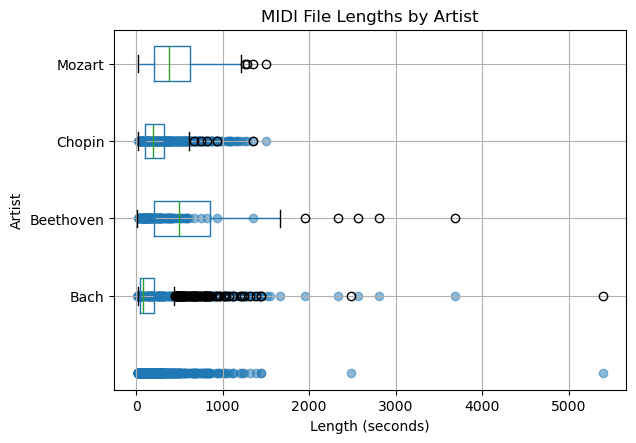

In [15]:
# Create the initial DataFrame directly from the dictionary
midi_file_lengths_df = pd.DataFrame(list(all_midi_lengths.items()), columns=['Path', 'Length'])
midi_file_lengths_df['Artist'] = midi_file_lengths_df['Path'].apply(lambda x: next((artist for artist in specific_artists if artist in x), 'Unknown'))

# Create horizontal box plots
plt.figure(figsize=(12, 8))
midi_file_lengths_df.boxplot(by='Artist', column=['Length'], vert=False)
plt.scatter(midi_file_lengths_df['Length'], midi_file_lengths_df['Artist'], alpha=0.5)
plt.title('MIDI File Lengths by Artist')
plt.suptitle('')
plt.xlabel('Length (seconds)')
plt.ylabel('Artist')
plt.yticks(rotation=0)
plt.show()

#### Temple Change Augmentation to handle class imbalance.

In [16]:
# Data Augmentation (Pitch Shifting)
def augment_midi_pitch_shift(file_path, output_dir, shift=2):
    try:
        midi_file = MidiFile(file_path)
        new_midi_file = MidiFile()

        for track in midi_file.tracks:
            new_track = mido.MidiTrack()
            new_midi_file.tracks.append(new_track)
            for msg in track:
                if msg.type == 'note_on' or msg.type == 'note_off':
                    msg.note = min(max(msg.note + shift, 0), 127)
                new_track.append(msg)

        output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.mid', f'_pitch_{shift}.mid'))
        new_midi_file.save(output_path)

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")

augmented_pitch_dir = os.path.join(raw_data_extracted, 'augmented_pitch')
os.makedirs(augmented_pitch_dir, exist_ok=True)

for root, dirs, files in os.walk(raw_data_extracted):
    for file in files:
        if file.endswith('.mid'):
            if 'Beethoven' in os.path.join(root, file) or 'Chopin' in os.path.join(root, file) or 'Mozart' in os.path.join(root, file):
                augment_midi_pitch_shift(os.path.join(root, file), augmented_pitch_dir, shift=2)
                augment_midi_pitch_shift(os.path.join(root, file), augmented_pitch_dir, shift=-2)

Error processing raw_data_unzipped\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Error processing raw_data_unzipped\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


## Feature Extraction

Features to be extracted from MIDI files:
- length
- num_notes
- note_freq
- tempo_changes
- velocities
- time_sigs
- key_sigs
- polyphony


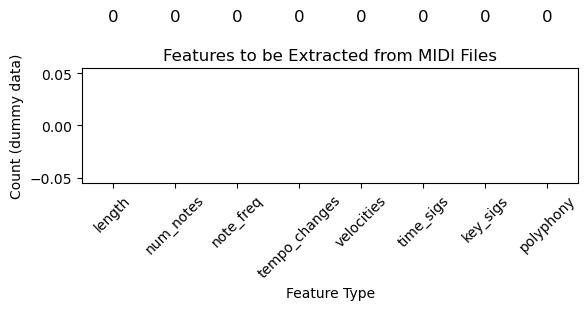

In [17]:
# Feature Extraction
features_to_extract = ['length', 'num_notes', 'note_freq', 'tempo_changes', 'velocities', 'time_sigs', 'key_sigs', 'polyphony']

print("Features to be extracted from MIDI files:")
for feature in features_to_extract:
    print(f"- {feature}")

example_feature_data = {
    'feature': features_to_extract,
    'count': [0] * len(features_to_extract)
}

example_df = pd.DataFrame(example_feature_data)

# Enhanced bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='feature', y='count', data=example_df, palette='viridis')
plt.title('Features to be Extracted from MIDI Files', fontsize=12)
plt.xlabel('Feature Type', fontsize=10)
plt.ylabel('Count (dummy data)', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add count labels on top of bars
for index, row in example_df.iterrows():
    plt.text(index, row['count'] + 0.1, f"{row['count']}", color='black', ha="center", fontsize=12)

plt.tight_layout()
plt.show()

#### Extract Features Function

In [18]:
# Feature Extraction
def extract_features(file_path):
    try:
        midi_file = MidiFile(file_path)
        features = {
            'length': 0,
            'num_notes': 0,
            'note_freq': Counter(),
            'tempo_changes': [],
            'velocities': [],
            'time_sigs': Counter(),
            'key_sigs': Counter(),
            'polyphony': []
        }

        note_on_times = {}
        polyphony_count = Counter()

        for track in midi_file.tracks:
            current_time = 0.0
            for msg in track:
                current_time += tick2second(msg.time, midi_file.ticks_per_beat, bpm2tempo(120))

                if msg.type == 'note_on' and msg.velocity > 0:
                    features['num_notes'] += 1
                    features['note_freq'][msg.note] += 1
                    features['velocities'].append(msg.velocity)
                    if current_time in note_on_times:
                        note_on_times[current_time].append(msg.note)
                    else:
                        note_on_times[current_time] = [msg.note]
                elif msg.type == 'set_tempo':
                    features['tempo_changes'].append(mido.tempo2bpm(msg.tempo))
                elif msg.type == 'time_signature':
                    features['time_sigs'][(msg.numerator, msg.denominator)] += 1
                elif msg.type == 'key_signature':
                    features['key_sigs'][msg.key] += 1

        features['length'] = current_time

        for time, notes in note_on_times.items():
            polyphony_count[len(notes)] += 1
        features['polyphony'] = polyphony_count

    except mido.KeySignatureError as e:
        print(f"Error processing {file_path}: {e}")
        return None
    except KeyError as e:
        print(f"KeyError processing {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error processing {file_path}: {e}")
        return None

    return features

In [19]:
# Extract features from all MIDI files, including augmented files
features_list = []

for root, dirs, files in os.walk(raw_data_extracted):
    for file in files:
        if file.endswith('.mid'):
            for artist in ['Bach', 'Beethoven', 'Chopin', 'Mozart']:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features['path'] = os.path.join(root, file)
                        features['artist'] = artist
                        features_list.append(features)

# Also include features from the augmented directory
for root, dirs, files in os.walk(augmented_pitch_dir):
    for file in files:
        if file.endswith('.mid'):
            for artist in ['Bach', 'Beethoven', 'Chopin', 'Mozart']:
                if artist in os.path.join(root, file):
                    features = extract_features(os.path.join(root, file))
                    if features:
                        features['path'] = os.path.join(root, file)
                        features['artist'] = artist
                        features_list.append(features)

# Convert to DataFrame for analysis
df = pd.DataFrame(features_list)

# Print extracted features
print("Extracted features:")
df.head()

Error processing raw_data_unzipped\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing raw_data_unzipped\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Extracted features:


,length,num_notes,note_freq,tempo_changes,velocities,time_sigs,key_sigs,polyphony,path,artist
0,79.500000,793,"{53: 73, 57: 66, 60: 107, 65: 88, 69: 23, 55: ...",[120.0],"[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...","{(4, 4): 1}",{},"{2: 76, 1: 528, 3: 36, 5: 1}",raw_data_unzipped\Bach\AveMaria.mid,Bach
1,482.133333,6077,"{70: 509, 74: 324, 77: 267, 75: 392, 79: 208, ...","[75.0, 70.00007000007, 65.000065000065, 50.0, ...","[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9...","{(4, 4): 1, (12, 8): 1, (3, 4): 1}",{},"{3: 575, 1: 1602, 2: 1375}",raw_data_unzipped\Bach\Bwv0525 Sonate en trio ...,Bach
2,575.666667,5379,"{79: 143, 63: 250, 62: 251, 65: 291, 67: 397, ...","[80.0, 78.000078000078, 75.0, 70.0002333341111...","[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9...","{(4, 4): 2, (3, 4): 1}",{},"{3: 403, 2: 1325, 1: 1512, 4: 2}",raw_data_unzipped\Bach\Bwv0526 Sonate en trio ...,Bach
3,394.000000,6056,"{77: 262, 76: 355, 74: 456, 73: 101, 79: 182, ...","[60.0, 50.0, 30.0, 60.0, 55.00000458333371, 50...","[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9...","{(2, 4): 1, (6, 8): 1, (3, 8): 1}",{},"{2: 97, 1: 5817, 3: 15}",raw_data_unzipped\Bach\Bwv0527 Sonate en trio ...,Bach
4,266.333333,4221,"{64: 300, 67: 252, 71: 351, 60: 90, 62: 155, 5...","[40.0, 75.0, 70.00007000007, 65.000065000065, ...","[92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 9...","{(4, 4): 2, (3, 4): 1, (3, 8): 1}",{},"{1: 2295, 2: 582, 3: 254}",raw_data_unzipped\Bach\Bwv0528 Sonate en trio ...,Bach


In [20]:
# Handling Outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

for col in ['length', 'num_notes']:
    handle_outliers(df, col)

#### EDA Visuals

<Figure size 1200x600 with 0 Axes>

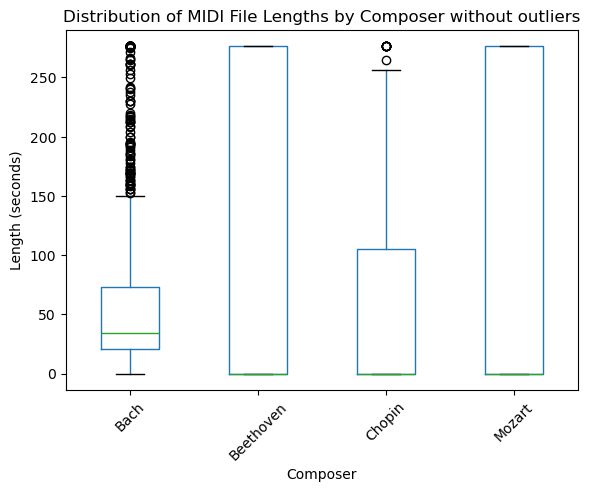

In [21]:
# Distribution of MIDI file lengths by composer after outlier removal
plt.figure(figsize=(12, 6))
df.boxplot(by='artist', column=['length'], grid=False)
plt.title('Distribution of MIDI File Lengths by Composer without outliers')
plt.suptitle('')
plt.xlabel('Composer')
plt.ylabel('Length (seconds)')
plt.xticks(rotation=45)
plt.show()

<Figure size 600x400 with 0 Axes>

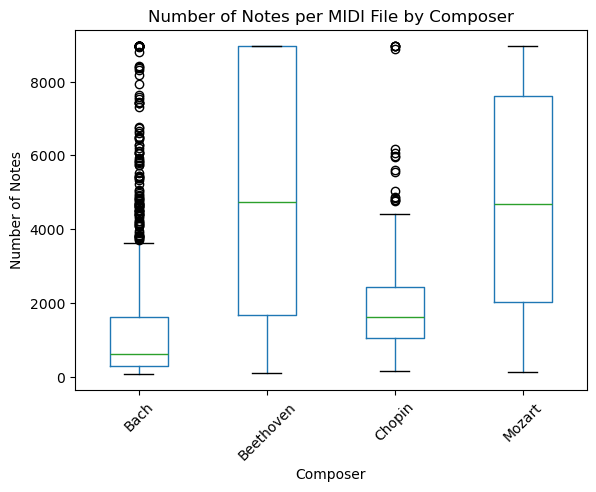

In [22]:
# Number of notes per MIDI file by composer
plt.figure(figsize=(6, 4))
df.boxplot(by='artist', column=['num_notes'], grid=False)
plt.title('Number of Notes per MIDI File by Composer')
plt.suptitle('')
plt.xlabel('Composer')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45)
plt.show()

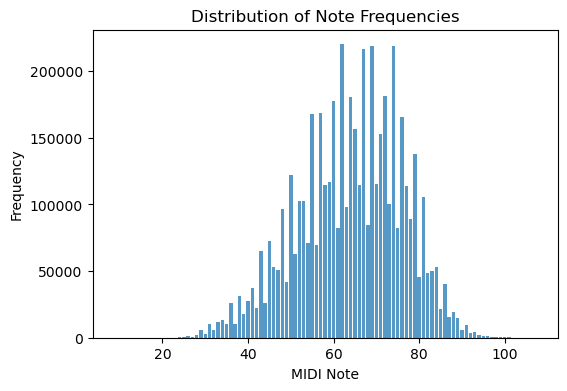

In [23]:
# Distribution of note frequencies
note_freqs = Counter()
for note_counter in df['note_freq']:
    note_freqs.update(note_counter)

plt.figure(figsize=(6, 4))
plt.bar(note_freqs.keys(), note_freqs.values(), alpha=0.75)
plt.title('Distribution of Note Frequencies')
plt.xlabel('MIDI Note')
plt.ylabel('Frequency')
plt.show()

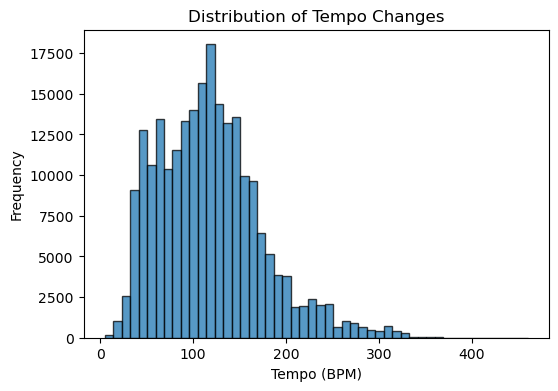

In [24]:
# Distribution of tempo changes
tempo_changes = [tempo for sublist in df['tempo_changes'] for tempo in sublist]

plt.figure(figsize=(6, 4))
plt.hist(tempo_changes, bins=50, alpha=0.75, edgecolor='black')
plt.title('Distribution of Tempo Changes')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.show()

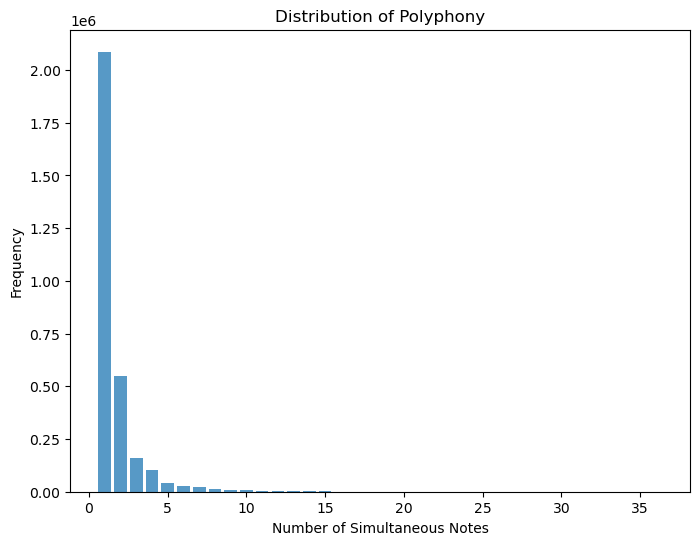

In [25]:
# Distribution of polyphony
polyphony_count = Counter()
for polyphony_counter in df['polyphony']:
    polyphony_count.update(polyphony_counter)

plt.figure(figsize=(8, 6))
plt.bar(polyphony_count.keys(), polyphony_count.values(), alpha=0.75)
plt.title('Distribution of Polyphony')
plt.xlabel('Number of Simultaneous Notes')
plt.ylabel('Frequency')
plt.show()

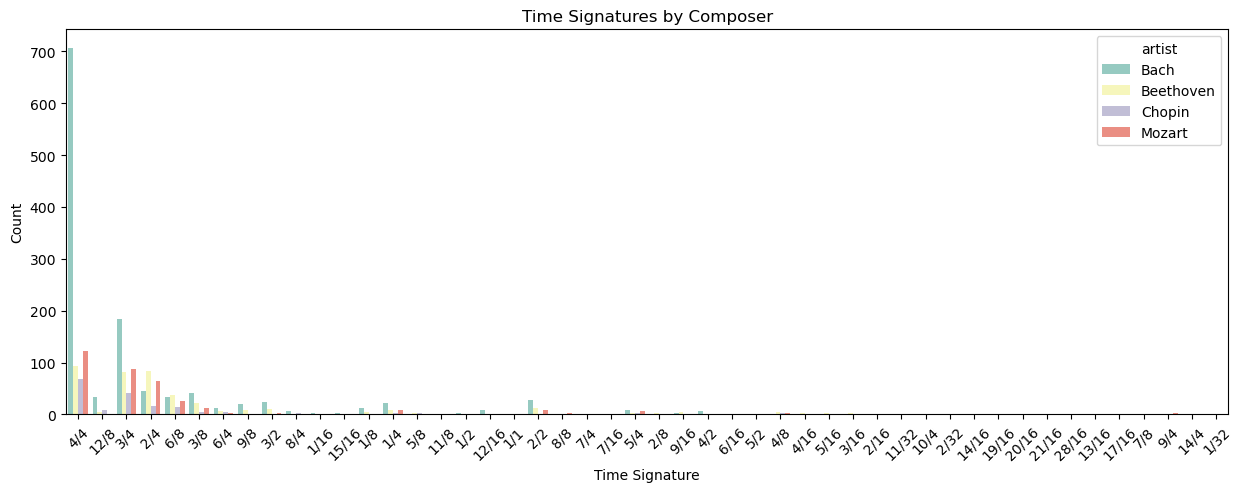

In [26]:
# Time signatures by composer
time_sigs_flat = []
for idx, row in df.iterrows():
    for time_sig, count in row['time_sigs'].items():
        time_sigs_flat.append({'artist': row['artist'], 'time_signature': f'{time_sig[0]}/{time_sig[1]}', 'count': count})

time_sigs_df = pd.DataFrame(time_sigs_flat)

plt.figure(figsize=(15, 5))
sns.countplot(data=time_sigs_df, x='time_signature', hue='artist', palette='Set3')
plt.title('Time Signatures by Composer')
plt.xlabel('Time Signature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

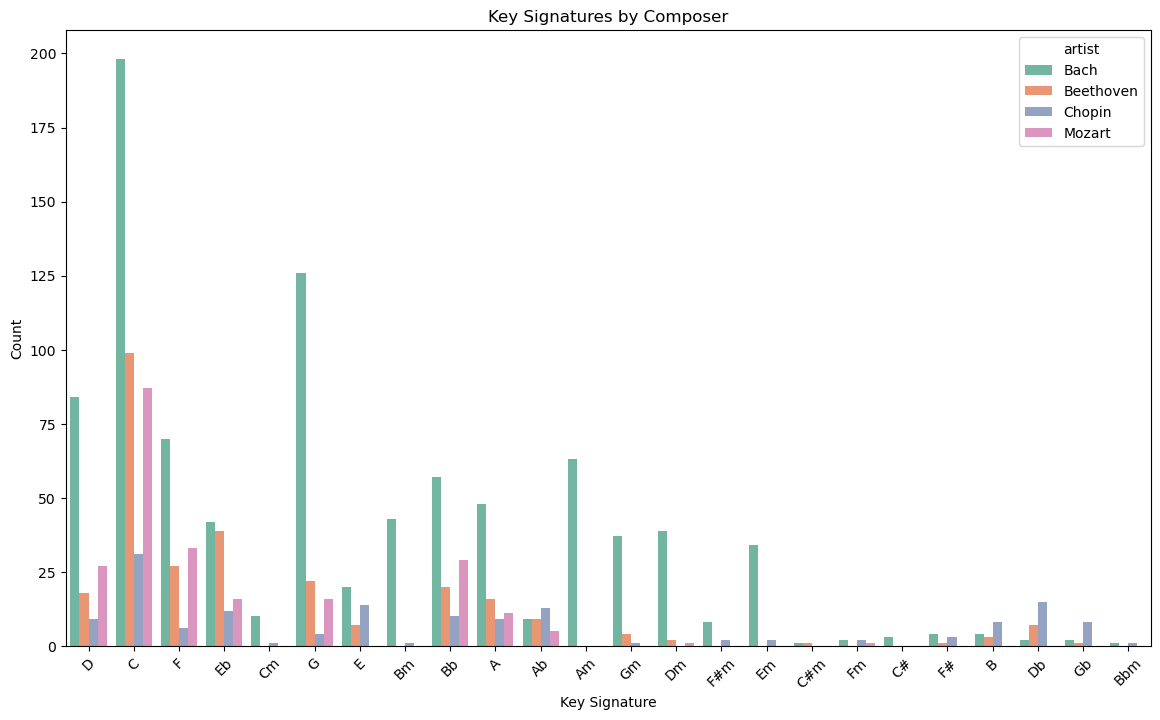

In [27]:
# Key signatures by composer
key_sigs_flat = []
for idx, row in df.iterrows():
    for key_sig, count in row['key_sigs'].items():
        key_sigs_flat.append({'artist': row['artist'], 'key_signature': key_sig, 'count': count})

key_sigs_df = pd.DataFrame(key_sigs_flat)

plt.figure(figsize=(14, 8))
sns.countplot(data=key_sigs_df, x='key_signature', hue='artist', palette='Set2')
plt.title('Key Signatures by Composer')
plt.xlabel('Key Signature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Ten Second Random Audio samples for each Composer

In [28]:
# Function to list MIDI files for a composer
def list_midi_files(directory, composer):
    composer_dir = os.path.join(directory, composer)
    return [os.path.join(composer_dir, file) for file in os.listdir(composer_dir) if file.endswith('.mid')]

# Function to play a MIDI file for a specified duration
def play_midi(file_path, duration=10):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()
    time.sleep(duration)
    pygame.mixer.music.stop()

# Dictionary to hold a randomly selected MIDI file for each composer
selected_files = {}

# Select one random MIDI file for each composer
for composer in specific_artists:
    midi_files = list_midi_files(base_directory, composer)
    if midi_files:
        selected_files[composer] = random.choice(midi_files)
    else:
        print(f"No MIDI files found for {composer}")

# Play the selected MIDI files
for composer, file_path in selected_files.items():
    print(f"Playing {composer}'s selected MIDI file: {file_path}")
    play_midi(file_path)

Playing Bach's selected MIDI file: raw_data_unzipped\Bach\Bwv0816 French Suite n5.mid
Playing Beethoven's selected MIDI file: raw_data_unzipped\Beethoven\Piano Sonatina in G Op79.mid
Playing Chopin's selected MIDI file: raw_data_unzipped\Chopin\19 Polish Songs, for Solo Voice and Piano accomplements, No.11.mid
Playing Mozart's selected MIDI file: raw_data_unzipped\Mozart\K299 Flute Harp Concerto 3mov.mid


## Model Building

#### Load Dataset

In [29]:
import pandas as pd

# Load the dataset
df = pd.read_csv('extracted_features.csv')

# Display the first few rows to ensure it loaded correctly
print(df.head())

   length  num_notes                                          note_freq  \
0     2.0       7009  Counter({63: 720, 58: 565, 75: 473, 65: 443, 6...   
1     0.0       3536  Counter({65: 254, 67: 243, 60: 211, 72: 196, 7...   
2     0.0      10671  Counter({62: 1031, 50: 940, 69: 938, 74: 891, ...   
3     0.0       4675  Counter({67: 498, 55: 335, 63: 296, 60: 281, 7...   
4     0.0       9047  Counter({60: 806, 67: 572, 72: 562, 79: 546, 5...   

                                       tempo_changes  \
0  [116.00008506672904, 58.00004253336452, 116.00...   
1             [64.99999458333379, 69.99998833333528]   
2  [234.000234000234, 234.50049440520903, 233.500...   
3  [60.0, 30.0, 60.0, 30.0, 60.0, 55.000004583333...   
4  [151.99993920002433, 140.5000866417201, 131.00...   

                                          velocities             time_sigs  \
0  [86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 8...  Counter({(4, 4): 1})   
1  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...  Co

#### Prepare Data for LSTM Model

In [30]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Handle missing values if any
df.fillna(0, inplace=True)

# Encode the artist labels
label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])

# Standardize the features
scaler = StandardScaler()
numeric_features = ['length', 'num_notes']
scaled_features = scaler.fit_transform(df[numeric_features])

# Prepare sequences
X = []
y = []
sequence_length = 10  # Adjust as necessary

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:i + sequence_length])
    y.append(df['artist_encoded'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1298, 10, 2) (325, 10, 2) (1298, 4) (325, 4)


#### Define the LSTM Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,740 (456.02 KB)

 Trainable params: 116,740 (456.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [32]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5800 - loss: 1.1008 - val_accuracy: 0.6154 - val_loss: 0.7960
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6983 - loss: 0.7342 - val_accuracy: 0.6400 - val_loss: 0.7353
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6981 - loss: 0.6978 - val_accuracy: 0.6800 - val_loss: 0.6738
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6904 - loss: 0.7093 - val_accuracy: 0.6646 - val_loss: 0.6581
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7054 - loss: 0.6243 - val_accuracy: 0.6677 - val_loss: 0.6868
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6958 - loss: 0.6596 - val_accuracy: 0.7231 - val_loss: 0.6204
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7326 - loss: 0.6076 - val_accuracy: 0.7015 - val_loss: 0.6111
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7473 - loss: 0.5747 - val_accuracy: 0.7415 - v

#### Evaluate the Model

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Convert encoded labels back to original
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Display some predictions
for i in range(10):
    print(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9162 - loss: 0.2219 
Test Loss: 0.24526888132095337, Test Accuracy: 0.9015384912490845
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
True: Mozart, Predicted: Mozart
True: Beethoven, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Chopin, Predicted: Beethoven


#### Visualize Training History

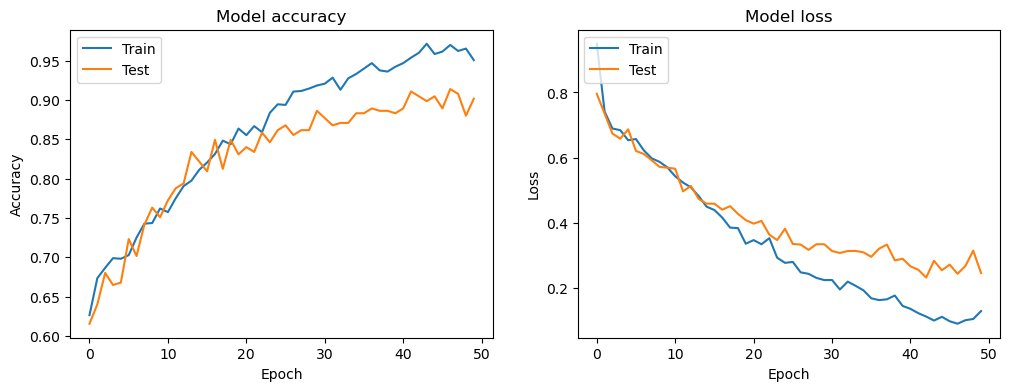

In [34]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#### Metrics

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9162 - loss: 0.2219 
Test Loss: 0.24526888132095337, Test Accuracy: 0.9015384912490845
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.95      0.94       191
   Beethoven       0.89      0.84      0.86        49
      Chopin       0.74      0.76      0.75        34
      Mozart       0.94      0.86      0.90        51

    accuracy                           0.90       325
   macro avg       0.87      0.85      0.86       325
weighted avg       0.90      0.90      0.90       325



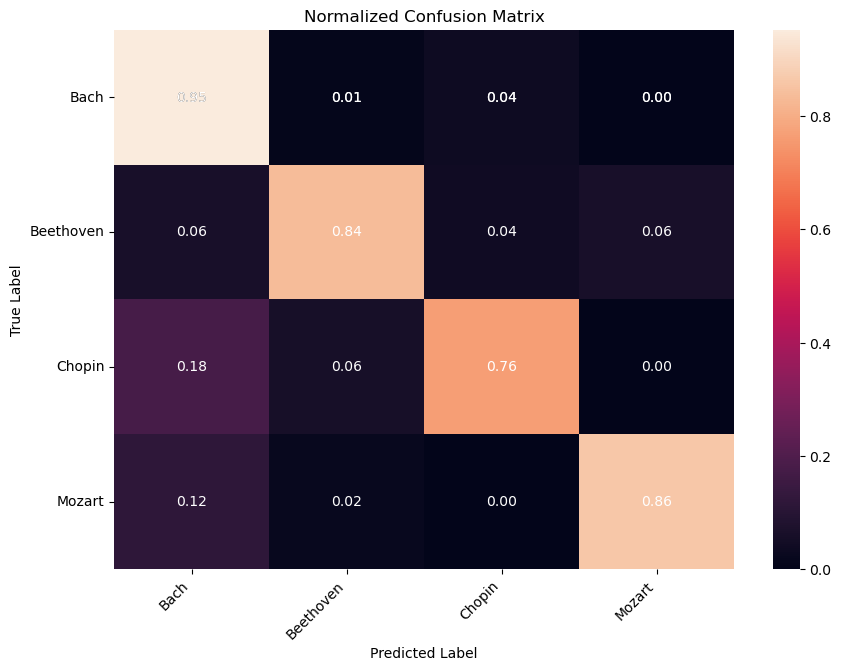

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Convert encoded labels back to original
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Annotate each cell with the numeric value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_normalized[i, j]:.2f}", horizontalalignment='center', verticalalignment='center', color='white')

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter tuning for LSTM

   length  num_notes                                          note_freq  \
0     2.0       7009  Counter({63: 720, 58: 565, 75: 473, 65: 443, 6...   
1     0.0       3536  Counter({65: 254, 67: 243, 60: 211, 72: 196, 7...   
2     0.0      10671  Counter({62: 1031, 50: 940, 69: 938, 74: 891, ...   
3     0.0       4675  Counter({67: 498, 55: 335, 63: 296, 60: 281, 7...   
4     0.0       9047  Counter({60: 806, 67: 572, 72: 562, 79: 546, 5...   

                                       tempo_changes  \
0  [116.00008506672904, 58.00004253336452, 116.00...   
1             [64.99999458333379, 69.99998833333528]   
2  [234.000234000234, 234.50049440520903, 233.500...   
3  [60.0, 30.0, 60.0, 30.0, 60.0, 55.000004583333...   
4  [151.99993920002433, 140.5000866417201, 131.00...   

                                          velocities             time_sigs  \
0  [86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 8...  Counter({(4, 4): 1})   
1  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...  Co

c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Score:  0.8774983605622558
Best Params:  {'model__optimizer': 'adam', 'model__lstm_units': 256, 'model__dropout_rate': 0.4, 'epochs': 70, 'batch_size': 64}
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9345 - loss: 0.1558
Test Loss: 0.1920708566904068, Test Accuracy: 0.9230769276618958
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
True: Mozart, Predicted: Mozart
True: Beethoven, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Chopin, Predicted: Chopin


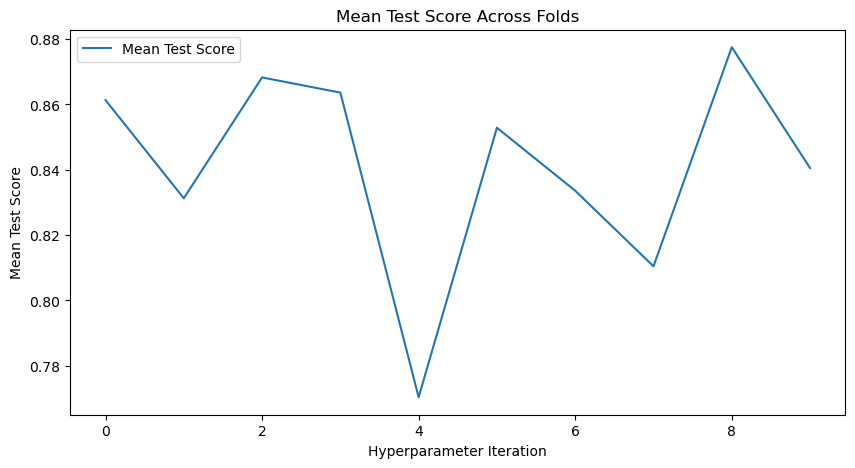

Classification Report:
              precision    recall  f1-score   support

        Bach       0.98      0.94      0.96       191
   Beethoven       0.82      0.92      0.87        49
      Chopin       0.82      0.91      0.86        34
      Mozart       0.92      0.86      0.89        51

    accuracy                           0.92       325
   macro avg       0.88      0.91      0.89       325
weighted avg       0.93      0.92      0.92       325



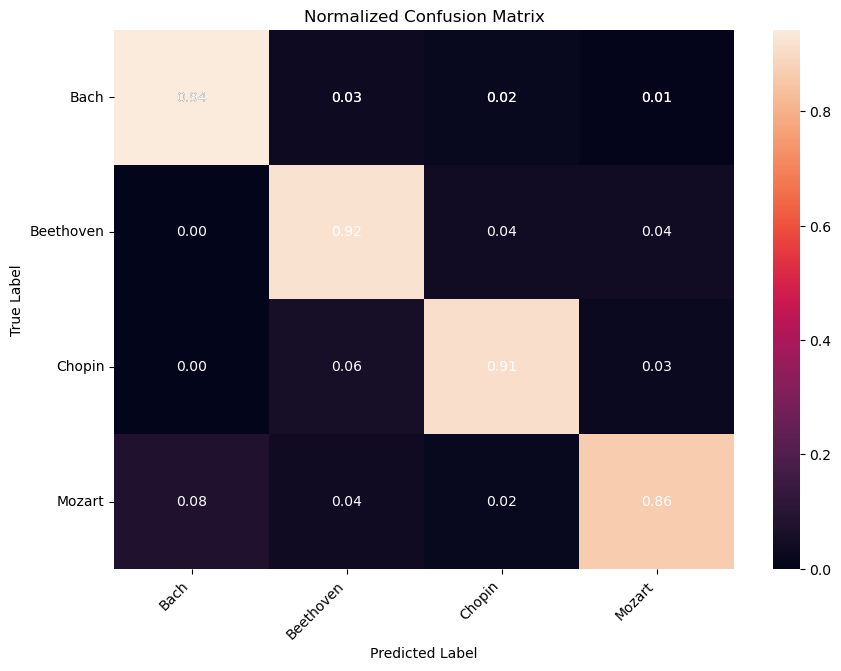

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('extracted_features.csv')

# Display the first few rows to ensure it loaded correctly
print(df.head())

# Handle missing values if any
df.fillna(0, inplace=True)

# Encode the artist labels
label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])

# Standardize the features
scaler = StandardScaler()
numeric_features = ['length', 'num_notes']
scaled_features = scaler.fit_transform(df[numeric_features])

# Prepare sequences
X = []
y = []
sequence_length = 10  # Adjust as necessary

for i in range(len(scaled_features) - sequence_length):
    X.append(scaled_features[i:i + sequence_length])
    y.append(df['artist_encoded'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define a function to create the model
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=128):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'epochs': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__lstm_units': [64, 128, 256]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=1)

# Fit the RandomizedSearchCV
random_search_result = random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best Score: ", random_search_result.best_score_)
print("Best Params: ", random_search_result.best_params_)

# Evaluate the best model on the test set
best_model = random_search_result.best_estimator_.model_
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Convert encoded labels back to original
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Display some predictions
for i in range(10):
    print(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")

import matplotlib.pyplot as plt

# Plot the mean cross-validated score
mean_test_scores = random_search_result.cv_results_['mean_test_score']
plt.figure(figsize=(10, 5))
plt.plot(mean_test_scores, label='Mean Test Score')
plt.title('Mean Test Score Across Folds')
plt.xlabel('Hyperparameter Iteration')
plt.ylabel('Mean Test Score')
plt.legend()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Annotate each cell with the numeric value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_normalized[i, j]:.2f}", horizontalalignment='center', verticalalignment='center', color='white')

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The results from the RandomizedSearchCV, displayed in the Mean Test Score Across Folds graph, underscore the importance of precise hyperparameter tuning for LSTM networks. The graph shows performance peaks at certain settings, highlighting how sensitive LSTM models are to their configuration, which emphasizes the need for careful hyperparameter optimization.

The analysis using the normalized confusion matrix and classification report reveals the model's capability to distinguish between composers, with notable success for Bach. However, some confusion between composers suggests room for improvement, possibly by refining the feature set or model architecture. This could involve integrating unique musical features or experimenting with different sequence lengths and class weights to enhance the model's accuracy further. The strategic use of LSTM and detailed hyperparameter tuning has proven effective in navigating the complexities of musical data classification.

### Hyperparameter tuning with weight imbalance management

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9544 - loss: 0.1668  
Test Loss: 0.22872191667556763, Test Accuracy: 0.9353846311569214
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
True: Mozart, Predicted: Mozart
True: Beethoven, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Bach
True: Bach, Predicted: Beethoven
True: Bach, Predicted: Bach
True: Chopin, Predicted: Chopin
Classification Report:
              precision    recall  f1-score   support

        Bach       0.96      0.95      0.96       191
   Beethoven       0.88      0.92      0.90        49
      Chopin       0.87      0.97      0.92        34
      Mozart       0.94      0.86      0.90        51

    accuracy                           0.94       325
   macro avg       0.91      0.93      0.92       325
weighted avg       0.94      0.94      0.94       325



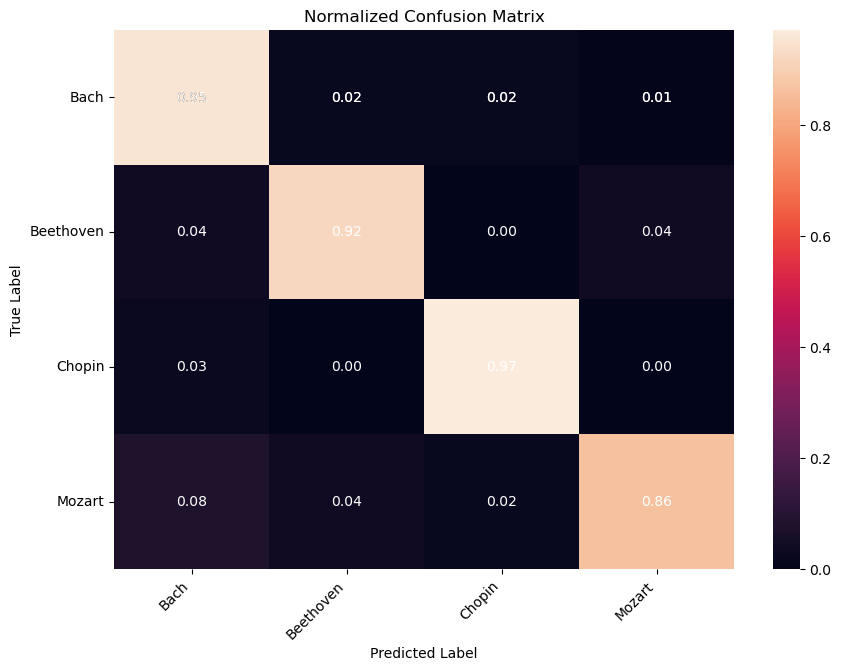

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Load the dataset
df = pd.read_csv('extracted_features.csv')
df.fillna(0, inplace=True)  # Handle missing values

# Encode the artist labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['artist'])
y = to_categorical(y_encoded)

# Standardize the features
scaler = StandardScaler()
numeric_features = df[['length', 'num_notes']]  # Assuming these are the numeric features
X_scaled = scaler.fit_transform(numeric_features)

# Prepare sequences
sequence_length = 10  # Sequence length for LSTM input
X = np.array([X_scaled[i: i + sequence_length] for i in range(len(X_scaled) - sequence_length)])
y = y[sequence_length:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights for handling class imbalance directly in model training
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded[sequence_length:])
class_weight_dict = dict(enumerate(class_weights))

# Define a function to create the LSTM model
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=128):
    model = Sequential([
        LSTM(lstm_units, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize KerasClassifier for use with scikit-learn
model = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)

# Define hyperparameters grid for RandomizedSearchCV
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__lstm_units': [64, 128, 256]
}

# Randomized Search to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1, n_jobs=-1)
random_search_result = random_search.fit(X_train, y_train, class_weight=class_weight_dict)

# Retrieve the best model after Randomized Search
best_model = random_search_result.best_estimator_.model_

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(true_classes)

# Display some prediction results
for i in range(10):
    print(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Annotate each cell with the numeric value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_normalized[i, j]:.2f}", horizontalalignment='center', verticalalignment='center', color='white')

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

After implementing changes to the LSTM model, including hyperparameter tuning and the application of class weights to manage class imbalances, there has been a noticeable improvement in the model's performance across different composers. The comparison of the model's performance before and after these changes is detailed below:

### Model Performance Before Changes:
- **Bach**: Exhibited very high precision and recall, indicating strong accuracy.
- **Beethoven**: Had decent precision but slightly lower recall, leading to some misclassifications.
- **Chopin**: Demonstrated lower precision, suggesting confusion with other composers.
- **Mozart**: Showed good precision but lower recall, indicating missed classifications of Mozart's pieces.

### Model Performance After Changes:
- **Bach**: Continued to show high precision with a slight improvement in recall.
- **Beethoven**: Displayed improved precision and recall, indicating a reduction in misclassifications.
- **Chopin**: Significant improvements were observed in both precision and recall, notably reducing misclassifications.
- **Mozart**: Both precision and recall improved, leading to more accurate identification.

The enhancements to the model have led to an overall increase in accuracy and classification precision across all composers, especially for Chopin and Mozart, who showed the most notable improvements. These changes suggest that the model is now better at correctly identifying pieces by these composers without confusing them with others. The application of class weights has particularly helped in boosting the model's performance by ensuring that all classes are treated proportionately during training, thus reducing the impact of class imbalance.

The implementation of hyperparameter tuning via RandomizedSearchCV has optimized the model's learning process, leading to more effective generalization on unseen data. This is evident from the improved precision and recall rates across the board, with a significant reduction in misclassification errors.

The modifications to the LSTM model, including the strategic adjustments to hyperparameters and the incorporation of class weights, have robustly enhanced its classification capabilities. The model now not only maintains its high accuracy for composers like Bach but also shows marked improvements in identifying composers whose pieces were previously challenging to classify correctly. This indicates a successful refinement in the model's ability to discriminate between subtle nuances in different classical music compositions.

Zain's Code


Testing with file format

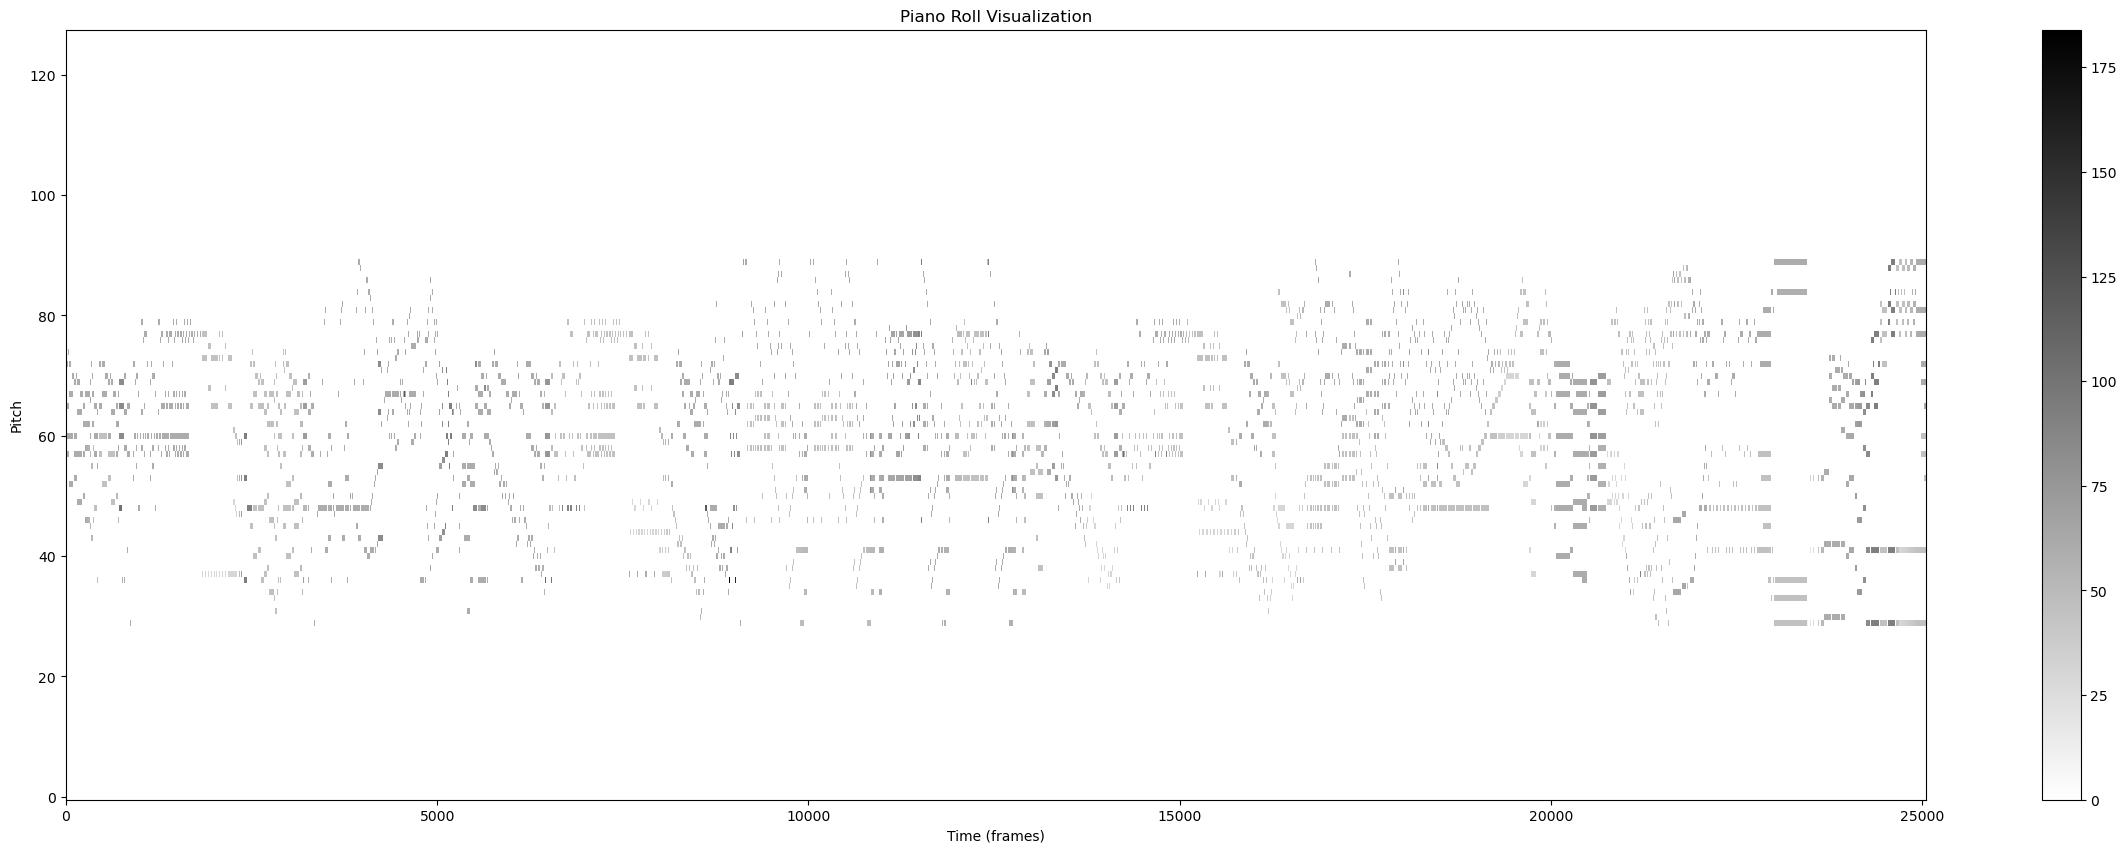

In [108]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt


test_file = 'raw_data_unzipped\Beethoven\Andante in F Major.mid'
# Load MIDI file
midi_data = pretty_midi.PrettyMIDI(test_file)

# Generate piano roll
piano_roll = midi_data.get_piano_roll(fs=100)

# Plot piano roll
plt.figure(figsize=(30, 10))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', interpolation='nearest')
plt.xlabel('Time (frames)')
plt.ylabel('Pitch')
plt.title('Piano Roll Visualization')
plt.colorbar()
plt.show()


In [109]:
import pretty_midi
import numpy as np

import pretty_midi
import numpy as np

def process_multichannel_midi(file_path, fs=10, max_length=100):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)
    
    # Binary channel
    piano_roll = midi_data.get_piano_roll(fs=fs)
    binary_piano_roll = (piano_roll > 0).astype(int)
    
    # Velocity channel (using the same piano_roll, normalized)
    velocity_roll = piano_roll / 127  # Normalize velocity

    # Instrumentation channel (collect rolls and find maximum length)
    instrument_rolls = []
    for instrument in midi_data.instruments:
        inst_roll = instrument.get_piano_roll(fs=fs)
        instrument_rolls.append(inst_roll)
    
    max_instrument_length = max(inst.shape[1] for inst in instrument_rolls)
    
    # Create a combined instrument roll with maximum length
    combined_instrument_roll = np.zeros((128, max_instrument_length))
    for inst_roll in instrument_rolls:
        if inst_roll.shape[1] < max_instrument_length:
            # Pad to the right if shorter
            padding = np.zeros((128, max_instrument_length - inst_roll.shape[1]))
            inst_roll = np.hstack((inst_roll, padding))
        combined_instrument_roll += (inst_roll > 0).astype(int)
    
    # Expressive timing channel (calculate note durations)
    expressive_timing_roll = np.zeros((128, max_instrument_length))
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = int(note.start * fs)
            end = int(note.end * fs)
            expressive_timing_roll[note.pitch, start:end] = 1  # Mark the duration as 1 (simplistic approach)

    # Ensure all rolls match the desired max_length
    if max_instrument_length > max_length:
        combined_instrument_roll = combined_instrument_roll[:, :max_length]
        expressive_timing_roll = expressive_timing_roll[:, :max_length]
    elif max_instrument_length < max_length:
        padding = np.zeros((128, max_length - max_instrument_length))
        combined_instrument_roll = np.hstack((combined_instrument_roll, padding))
        expressive_timing_roll = np.hstack((expressive_timing_roll, padding))
    
    # Normalize binary and velocity rolls to max_length
    binary_piano_roll = binary_piano_roll[:, :max_length]
    velocity_roll = velocity_roll[:, :max_length]

    # Stack channels
    multichannel_roll = np.stack([binary_piano_roll, velocity_roll, combined_instrument_roll, expressive_timing_roll], axis=-1)
    
    return multichannel_roll

import matplotlib.pyplot as plt

def plot_multichannel_piano_roll(processed_data):
    # Unpack the channels
    binary_channel = processed_data[:, :, 0]
    velocity_channel = processed_data[:, :, 1]
    instrument_channel = processed_data[:, :, 2]
    expressive_timing_channel = processed_data[:, :, 3]  # Placeholder channel
    
    # Set up the plot
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16))
    titles = ['Binary Channel', 'Velocity Channel', 'Instrumentation Channel', 'Expressive Timing Channel']

    # Plot each channel
    for ax, channel, title in zip(axes, [binary_channel, velocity_channel, instrument_channel, expressive_timing_channel], titles):
        cax = ax.imshow(channel, aspect='auto', origin='lower', interpolation='nearest')
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Pitch')
        fig.colorbar(cax, ax=ax, orientation='vertical')
    
    plt.tight_layout()
    plt.show()



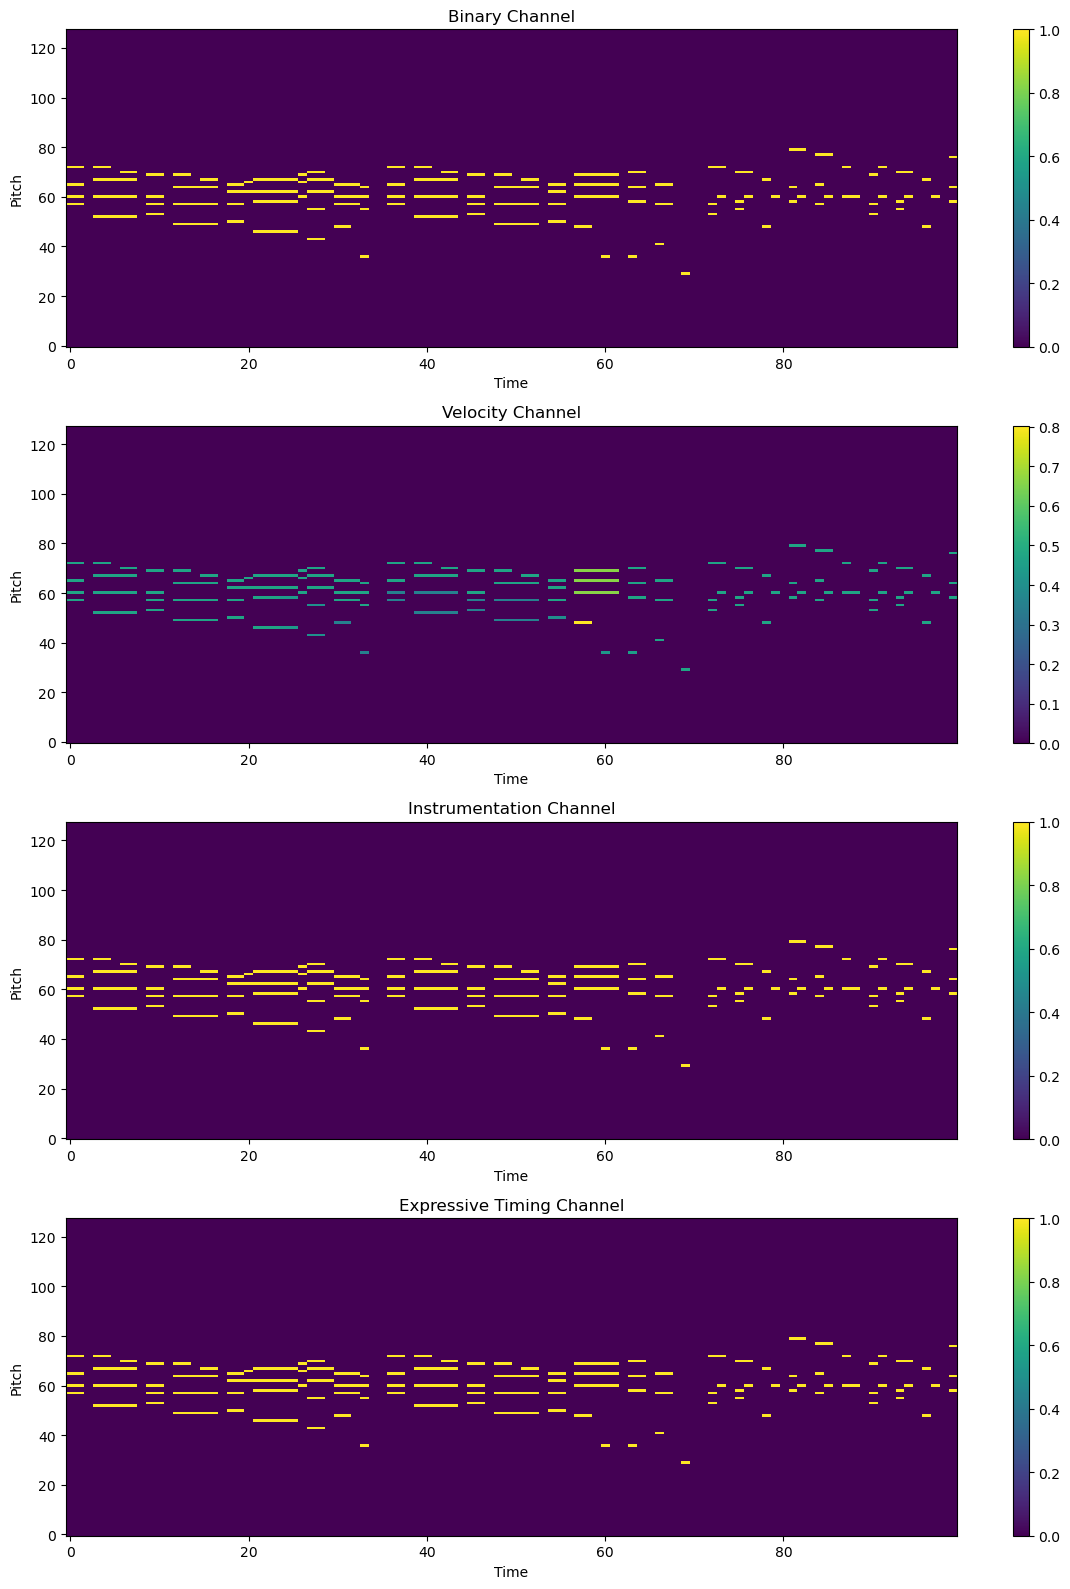

In [110]:
# Example use
file_path = test_file
processed_data = process_multichannel_midi(file_path, fs=8)

# Call the function with the processed data
plot_multichannel_piano_roll(processed_data)

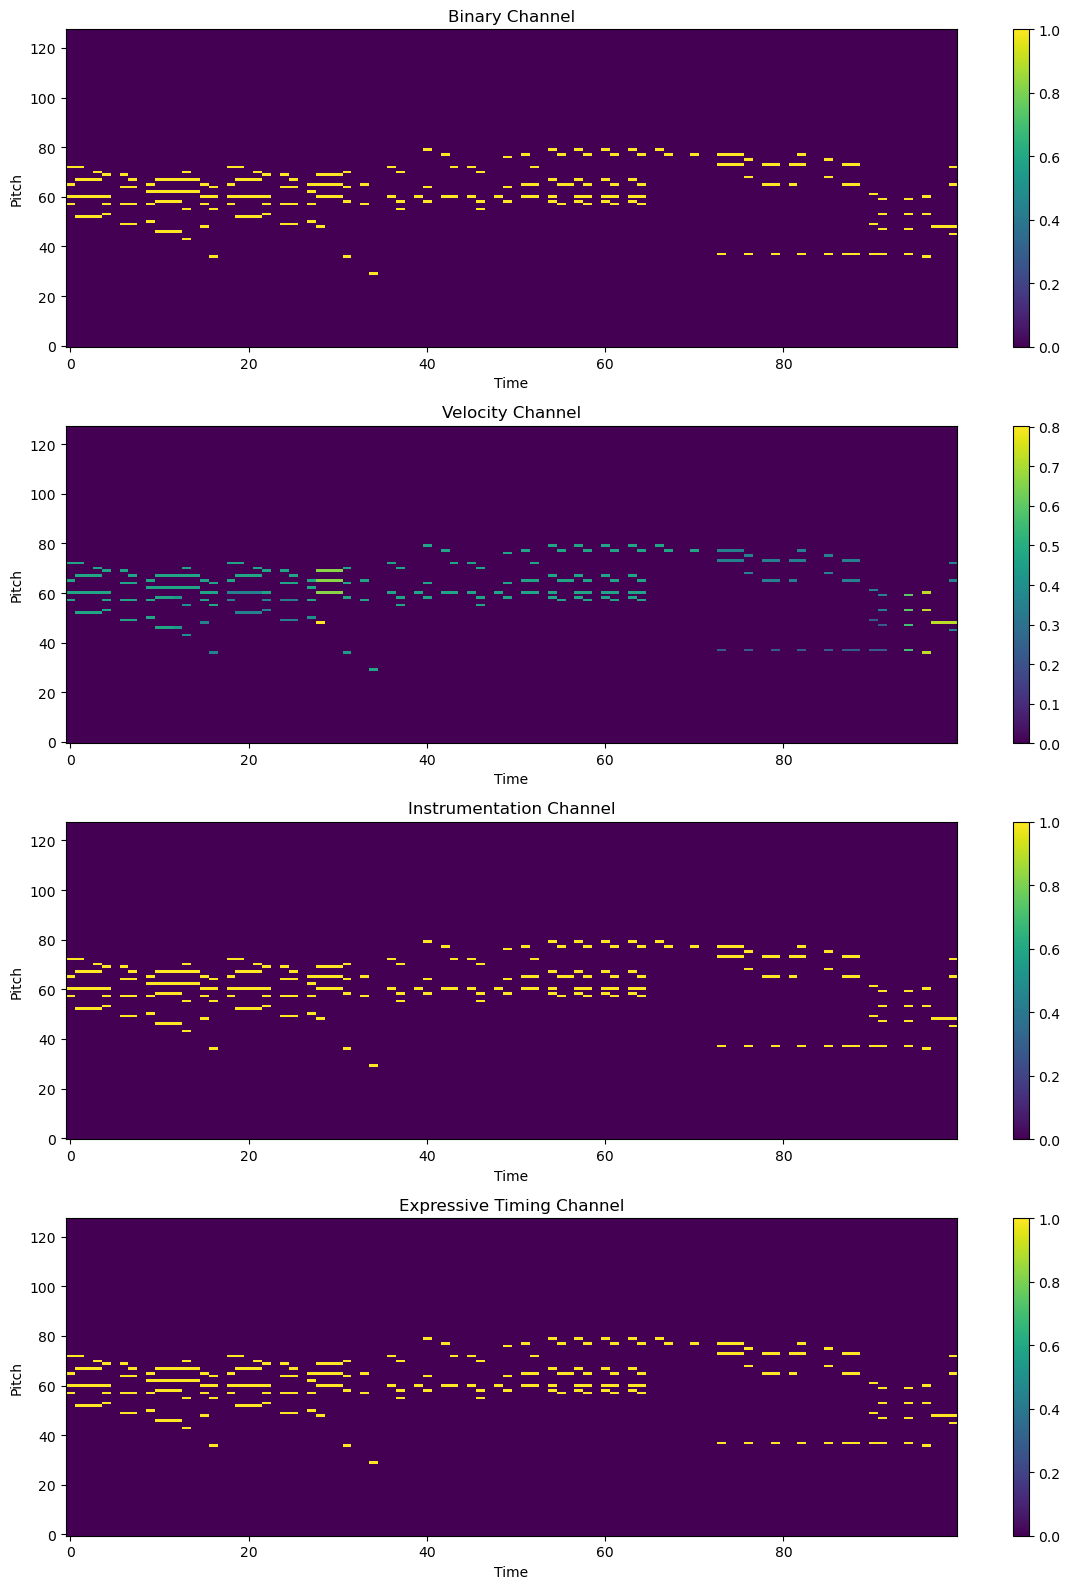

In [111]:
# Example use
file_path = test_file
processed_data = process_multichannel_midi(file_path, fs=4)

# Call the function with the processed data
plot_multichannel_piano_roll(processed_data)

In [112]:
import pretty_midi
import numpy as np

def midi_to_chunks(file_path, chunk_size=150, fs=10):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)
    
    # Get a piano roll array where the rows correspond to pitches and columns to time
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    # Number of chunks
    num_chunks = piano_roll.shape[1] // chunk_size
    
    # Prepare container for chunked data
    chunks = []
    
    # Create chunks
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunk = piano_roll[:, start:end]
        
        # Here you would apply your multichannel conversion
        binary = (chunk > 0).astype(int)
        velocity = chunk / 127
        # Add other channels as necessary
        
        # Stack channels along the third dimension
        multichannel_chunk = np.stack([binary, velocity], axis=-1)  # Add other channels similarly
        chunks.append(multichannel_chunk)
    
    # Handle last chunk if there is a remainder
    if piano_roll.shape[1] % chunk_size != 0:
        last_chunk = piano_roll[:, num_chunks * chunk_size:]
        # Padding the last chunk if necessary
        if last_chunk.shape[1] < chunk_size:
            padding = np.zeros((128, chunk_size - last_chunk.shape[1], 2))  # Adjust depth for number of channels
            last_chunk_padded = np.stack([(last_chunk > 0).astype(int), last_chunk / 127], axis=-1)  # Adjust for channels
            last_chunk_padded = np.concatenate([last_chunk_padded, padding], axis=1)
            chunks.append(last_chunk_padded)

    return chunks

file_path = test_file
chunks = midi_to_chunks(file_path)

In [113]:
import matplotlib.pyplot as plt

def visualize_chunks(chunks):
    num_chunks = len(chunks)
    fig, axes = plt.subplots(num_chunks, 2, figsize=(15, 3 * num_chunks))  # 2 columns for binary and velocity
    
    if num_chunks == 1:  # Ensure axes array does not collapse
        axes = [axes]

    for i, chunk in enumerate(chunks):
        # Binary Channel
        ax1 = axes[i][0] if num_chunks > 1 else axes[0]
        binary_channel = chunk[:, :, 0]  # Assuming binary channel is the first channel
        cax1 = ax1.imshow(binary_channel, aspect='auto', origin='lower', cmap='gray', interpolation='none')
        ax1.set_title(f'Chunk {i+1} - Binary Channel')
        ax1.set_xlabel('Time (frames)')
        ax1.set_ylabel('Pitch')
        fig.colorbar(cax1, ax=ax1, orientation='vertical')
        
        # Velocity Channel
        ax2 = axes[i][1] if num_chunks > 1 else axes[1]
        velocity_channel = chunk[:, :, 1]  # Assuming velocity channel is the second channel
        cax2 = ax2.imshow(velocity_channel, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
        ax2.set_title(f'Chunk {i+1} - Velocity Channel')
        ax2.set_xlabel('Time (frames)')
        ax2.set_ylabel('Pitch')
        fig.colorbar(cax2, ax=ax2, orientation='vertical')

    plt.tight_layout()
    plt.show()


In [114]:
import pretty_midi
import numpy as np

def midi_to_chunks(file_path, artist, fs=10, chunk_size=150):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)
    
    # Get a piano roll array
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    # Number of chunks and the last chunk size
    num_full_chunks = piano_roll.shape[1] // chunk_size
    last_chunk_size = piano_roll.shape[1] % chunk_size
    chunks = []
    
    # Process each full chunk
    for i in range(num_full_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunk_data = piano_roll[:, start:end]
        chunks.append((chunk_data, artist, file_path, i+1, 'No'))  # No padding added
    
    # Handle the last chunk if it's not a full chunk
    if last_chunk_size > 0:
        padding = np.zeros((128, chunk_size - last_chunk_size))
        last_chunk = np.hstack((piano_roll[:, -last_chunk_size:], padding))
        chunks.append((last_chunk, artist, file_path, num_full_chunks + 1, 'Yes'))  # Padding added
    
    return chunks


In [115]:
## Testing different chunk configurations


def midi_to_chunks(file_path, artist, fs=10, chunk_size=150, overlap=0.5):
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)
    
    # Get a piano roll array
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    # Calculate step size based on overlap
    step_size = int(chunk_size * (1 - overlap))
    
    # Initialize the chunks list
    chunks = []
    
    # Process each chunk with the specified overlap
    for start in range(0, piano_roll.shape[1], step_size):
        end = start + chunk_size
        if end <= piano_roll.shape[1]:
            chunk_data = piano_roll[:, start:end]
            chunks.append((chunk_data, artist, file_path, len(chunks) + 1, 'No'))
        else:
            # Handle the last chunk if it doesn't fit perfectly
            last_chunk_size = piano_roll.shape[1] - start
            padding = np.zeros((128, chunk_size - last_chunk_size))
            last_chunk = np.hstack((piano_roll[:, start:], padding))
            chunks.append((last_chunk, artist, file_path, len(chunks) + 1, 'Yes'))
            break
    
    return chunks


def midi_to_multi_scale_chunks(file_path, artist, fs=10, chunk_size = 150):

    small_chunk_size = int(chunk_size*0.75)
    large_chunk_size = chunk_size*2
    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(file_path)
    
    # Get a piano roll array
    piano_roll = midi_data.get_piano_roll(fs=fs)
    
    chunks = []
    
    # Process small chunks
    num_small_chunks = piano_roll.shape[1] // small_chunk_size
    for i in range(num_small_chunks):
        start = i * small_chunk_size
        end = start + small_chunk_size
        chunk_data = piano_roll[:, start:end]
        chunks.append((chunk_data, artist, file_path, f'small-{i+1}', 'No'))
    
    # Handle the last small chunk if it's not a full chunk
    last_small_chunk_size = piano_roll.shape[1] % small_chunk_size
    if last_small_chunk_size > 0:
        padding = np.zeros((128, small_chunk_size - last_small_chunk_size))
        last_small_chunk = np.hstack((piano_roll[:, -last_small_chunk_size:], padding))
        chunks.append((last_small_chunk, artist, file_path, f'small-{num_small_chunks + 1}', 'Yes'))
    
    # Process large chunks
    num_large_chunks = piano_roll.shape[1] // large_chunk_size
    for i in range(num_large_chunks):
        start = i * large_chunk_size
        end = start + large_chunk_size
        chunk_data = piano_roll[:, start:end]
        chunks.append((chunk_data, artist, file_path, f'large-{i+1}', 'No'))
    
    # Handle the last large chunk if it's not a full chunk
    last_large_chunk_size = piano_roll.shape[1] % large_chunk_size
    if last_large_chunk_size > 0:
        padding = np.zeros((128, large_chunk_size - last_large_chunk_size))
        last_large_chunk = np.hstack((piano_roll[:, -last_large_chunk_size:], padding))
        chunks.append((last_large_chunk, artist, file_path, f'large-{num_large_chunks + 1}', 'Yes'))
    
    return chunks


In [116]:
def process_all_files(df, base_url, fs=10, chunk_size=150):
    all_chunks = []
    for idx, row in df.iterrows():
        file_path = f"{base_url}/{row['Path']}"
        artist = row['Artist']
        chunks = midi_to_chunks(file_path, artist, fs, chunk_size)
        all_chunks.extend(chunks)
    
    # Create a new DataFrame
    columns = ['Chunk', 'Artist', 'Original Path', 'Chunk Number', 'Padding Added']
    chunk_df = pd.DataFrame(all_chunks, columns=columns)
    
    return chunk_df


In [117]:
import pandas as pd
midi_file_df  = pd.read_csv('midi_files_df.csv')

In [118]:
raw_data_extracted = 'raw_data_unzipped'  # Replace with the correct file path
processed_chunk_df = process_all_files(midi_file_df, raw_data_extracted, fs=8, chunk_size=150)

c:\Users\eterp\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


OSError: [Errno 22] Invalid argument: 'raw_data_unzipped/Bach/Bwv802 Four Inventions (Duettos) Clavier-U"bung III n1.mid'

In [119]:
print('How many chunks has padding')
print(processed_chunk_df["Padding Added"].value_counts())
print(processed_chunk_df["Padding Added"].value_counts(normalize=True) * 100)

# might want to check if removing the padded data has any effect.

How many chunks has padding
Padding Added
No     39509
Yes     1625
Name: count, dtype: int64
Padding Added
No     96.049497
Yes     3.950503
Name: proportion, dtype: float64


In [120]:
processed_chunk_df['Chunk'].iloc[0].shape

(128, 150)

In [121]:
def preprocess_chunks(dataframe, chunk_size=150):
    # Initialize an empty list to hold processed chunks
    processed_chunks = []
    
    # Iterate through each chunk in the DataFrame
    for chunk in dataframe['Chunk']:
        # Ensure the chunk is a numpy array and reshape if necessary
        if isinstance(chunk, np.ndarray):
            if chunk.shape[1] != chunk_size:
                # Check if padding is needed
                if chunk.shape[1] < chunk_size:
                    padding = np.zeros((128, chunk_size - chunk.shape[1]))
                    chunk = np.hstack((chunk, padding))
                else:
                    # Or truncation if the chunk is longer
                    chunk = chunk[:, :chunk_size]
            processed_chunks.append(chunk)
        else:
            # Log or handle cases where the chunk is not a numpy array
            print("Chunk is not a numpy array. Check data preparation steps.")
    
    # Convert list of arrays into a single 4D numpy array for CNN input
    X = np.stack(processed_chunks) / 127.0  # Normalize the MIDI velocities
    X = X.reshape(-1, 128, chunk_size, 1)  # Reshape for CNN
    return X

X = preprocess_chunks(processed_chunk_df, )


In [122]:
X.shape

(41134, 128, 150, 1)

In [123]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    
    # OneHotEncoder setup
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Ensure the output is dense
    integer_encoded = integer_encoded.reshape(-1, 1)  # Reshape for OneHotEncoder
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)  # No need for .toarray()
    
    return onehot_encoded, label_encoder

y, label_encoder = encode_labels(processed_chunk_df['Artist'])

In [124]:
y.shape

(41134, 4)

In [125]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(np.unique(processed_chunk_df['Artist'])), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 63, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 69120)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,847,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,866,820 (33.82 MB)

 Trainable params: 8,866,820 (33.82 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 1025s 993ms/step - accuracy: 0.5836 - loss: 0.9889 - val_accuracy: 0.7175 - val_loss: 0.6924
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 240s 233ms/step - accuracy: 0.7106 - loss: 0.7029 - val_accuracy: 0.7573 - val_loss: 0.6022
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 266s 259ms/step - accuracy: 0.7581 - loss: 0.5916 - val_accuracy: 0.7687 - val_loss: 0.5720
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 307s 299ms/step - accuracy: 0.7908 - loss: 0.5085 - val_accuracy: 0.7738 - val_loss: 0.5665
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 267s 260ms/step - accuracy: 0.8228 - loss: 0.4354 - val_accuracy: 0.7767 - val_loss: 0.5714
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 216s 210ms/step - accuracy: 0.8452 - loss: 0.3784 - val_accuracy: 0.7760 - val_loss: 0.5909
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 224s 217ms/step - accuracy: 0.8610 - loss: 0.3447 - val_accuracy: 0.7867 - val_loss: 0.6159
Epoch 8/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 213s 207ms/step - a

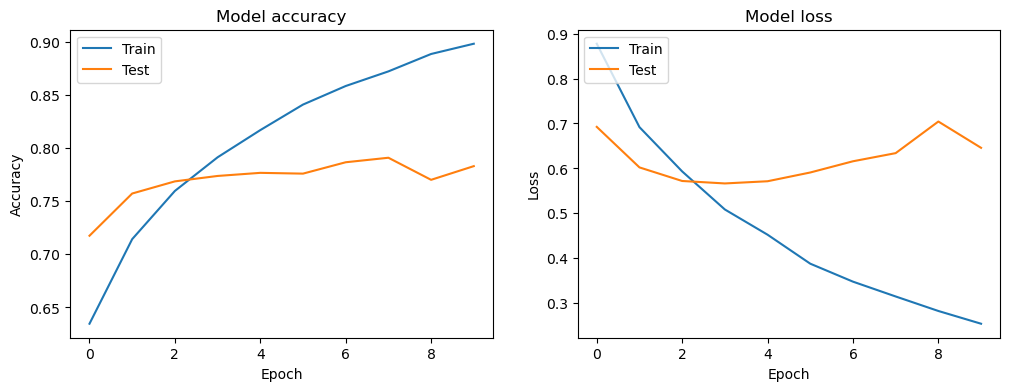

In [132]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [133]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.2f}, Validation loss: {val_loss:.2f}')

258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7885 - loss: 0.6544
Validation accuracy: 0.78, Validation loss: 0.65


In [134]:
predictions = model.predict(X_val)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.utils import shuffle
import ast

# Load the CSV file
df = pd.read_csv('processed_chunk_df.csv')

# Convert chunk column from string to numpy array
def convert_chunk_string_to_array(chunk_str):
    try:
        # Clean up the string for safe evaluation
        chunk_list = ast.literal_eval(chunk_str.replace('\n', '').replace('...', '0'))
        # Convert to NumPy array
        array = np.array(chunk_list)
        return array
    except (ValueError, SyntaxError) as e:
        print("Error converting string to array:", e)
        return np.zeros((128, 150))  # Return a zero array as a fallback

# Apply the conversion function
df['Chunk'] = df['Chunk'].apply(convert_chunk_string_to_array)

# Encode the labels
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded, label_encoder

# Preprocess chunks for CNN input
def preprocess_chunks(dataframe, chunk_size=150):
    processed_chunks = []
    
    for chunk in dataframe['Chunk']:
        if chunk.shape[1] != chunk_size:
            if chunk.shape[1] < chunk_size:
                padding = np.zeros((128, chunk_size - chunk.shape[1]))
                chunk = np.hstack((chunk, padding))
            else:
                chunk = chunk[:, :chunk_size]
        processed_chunks.append(chunk)
    
    X = np.stack(processed_chunks) / 127.0
    X = X.reshape(-1, 128, chunk_size, 1)
    return X

X = preprocess_chunks(df)
y, label_encoder = encode_labels(df['Artist'])

# Shuffle and split data
X, y = shuffle(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(128, 150, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(len(np.unique(df['Artist'])), activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='midi_classification'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Conv1 Filters: {best_hyperparameters.get('conv_1_filter')}")
print(f"Conv1 Kernel: {best_hyperparameters.get('conv_1_kernel')}")
print(f"Dropout1: {best_hyperparameters.get('dropout_1')}")
print(f"Conv2 Filters: {best_hyperparameters.get('conv_2_filter')}")
print(f"Conv2 Kernel: {best_hyperparameters.get('conv_2_kernel')}")
print(f"Dropout2: {best_hyperparameters.get('dropout_2')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout3: {best_hyperparameters.get('dropout_3')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

# Retrain the best model with all training data
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy:.2f}, Validation loss: {val_loss:.2f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Final evaluation
predictions = best_model.predict(X_val)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1), target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1))

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Annotate each cell with the numeric value
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{conf_matrix_normalized[i, j]:.2f}", horizontalalignment='center', verticalalignment='center', color='white')

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Trial 4 Complete [03h 37m 39s]
val_accuracy: 0.40606507658958435

Best val_accuracy So Far: 0.40606507658958435
Total elapsed time: 10h 10m 08s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
32                |128               |conv_1_filter
3                 |5                 |conv_1_kernel
0.4               |0.3               |dropout_1
64                |96                |conv_2_filter
5                 |3                 |conv_2_kernel
0.2               |0.1               |dropout_2
192               |64                |dense_units
0.1               |0                 |dropout_3
0.001             |0.001             |learning_rate

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 183s 267ms/step - accuracy: 0.4092 - loss: 1.3474 - val_accuracy: 0.4061 - val_loss: 1.2838
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 180s 266ms/step - accuracy: 0.4081 - loss: 1.2775 - val_accuracy: 0.4061 - val_loss: 1.2667
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 179s 265ms/step -

KeyboardInterrupt: 